<h1 style="text-align: center; color: darkred;">University of Padua</h1>
<h2 style="text-align: center;">Group 5: Game of Life</h2>
<h3 style="text-align: center;">Project Submission – 14/02/2025</h3>


<div style="text-align: center;">
    <img src="University_of_Padua_seal.png" alt="University of Padua Logo" width="150">
</div>

<h3>Team Members:</h3>
<ul>
    <li><b>Sebastian Waruszynski</b></li>
    <li><b>Martina Cassina</b></li>
    <li><b>Fredy Dairy</b></li>
    <li><b>Miguel Avilés</b></li>

In [5]:
from IPython.display import display, HTML, YouTubeVideo

video = YouTubeVideo("xP5-iIeKXE8", width=800, height=450)
display(HTML(f"<div style='display: flex; justify-content: center;'>{video._repr_html_()}</div>"))


# Introduction to the Game of Life
### Rules:

#### 1. A living cell with fewer than two or more than three neighbors dies.
A cell dies due to underpopulation or overpopulation.

#### 2. A living cell with two or three neighbors survives.
A stable formation remains unchanged.

#### 3. A dead cell with exactly three neighbors becomes alive.
A new cell is born due to reproduction.



<div style="text-align: center;">
    <img src="Rules-of-Conways-Game-of-Life.png" alt="Rules" width="400">
</div>

# Probability Distribution Over the Grid

The `generate_random` function creates a probability map for the grid by summing multiple Gaussian distributions. This method produces regions where the probability of a cell being active (or "alive") is higher, resulting in non-uniform patterns.

## How the Probability is Calculated

1. **Initial Parameters**  
   - **`m`**: The number of Gaussians (in this case, `m = 3`).
   - **`sigma`**: The standard deviation of the Gaussians (here, `sigma = 5`).

2. **Choosing the Centers**  
   For each Gaussian, a random center is chosen on the grid. These centers are represented by the coordinates \((r_k, c_k)\) for \(k = 1, 2, \dots, m\).

3. **Calculating the Gaussian Value for Each Cell**  
   For a cell at position \((i, j)\), the contribution from the Gaussian centered at \((r_k, c_k)\) is given by the formula:
   
   $$
   G_k(i, j) = \exp\left(-\frac{(i - r_k)^2 + (j - c_k)^2}{2\sigma^2}\right)
   $$
   
   - At the center \((r_k, c_k)\), the value is maximum (equal to 1).
   - As the distance from the center increases, the value decays exponentially.

4. **Summing the Gaussians and Normalization**  
   The total probability \(P(i, j)\) for cell \((i, j)\) is obtained by summing the contributions of all the Gaussians:
   
   $$
   P(i, j) = \sum_{k=1}^{m} G_k(i, j) = \sum_{k=1}^{m} \exp\left(-\frac{(i - r_k)^2 + (j - c_k)^2}{2\sigma^2}\right)
   $$
   
   To ensure that the probability values lie within the interval \([0, 1]\), the grid is normalized by dividing each value by the maximum probability in the grid:
   
   $$
   P_{\text{norm}}(i, j) = \frac{P(i, j)}{\max_{i,j}\, P(i, j)}
   $$

5. **Final Grid Generation**  
   Once the normalized probability map \(P_{\text{norm}}(i, j)\) is computed, a random number between 0 and 1 is generated for each cell.  
   The cell is activated (set to `True` or 1) if the random number is less than \(P_{\text{norm}}(i, j)\); otherwise, it remains inactive.


In [6]:
import time
import pygame
import numpy as np
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [12]:
COLOR_BG = (10, 10, 10) 
COLOR_GRID = (40, 40, 40) 
COLOR_DIE_NEXT = (170, 170, 170) 
COLOR_ALIVE_NEXT = (255, 182, 193)
COLOR_RANDOM = (255, 182, 193)

In [7]:
def update(screen, cells, size, with_progress=False):
    update_cells = np.zeros(cells.shape, dtype=int)

    rows, cols = cells.shape
    for row, col in np.ndindex(cells.shape):
        alive = sum(
            cells[(row + i) % rows, (col + j) % cols]
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
            if not (i == 0 and j == 0)
        )

        color = COLOR_BG if cells[row, col] == 0 else COLOR_ALIVE_NEXT

        if cells[row, col] == 1:
            if alive < 2 or alive > 3:
                if with_progress:
                    color = COLOR_DIE_NEXT
            elif 2 <= alive <= 3:
                update_cells[row, col] = 1
                if with_progress:
                    color = COLOR_ALIVE_NEXT
        else:
            if alive == 3:
                update_cells[row, col] = 1
                if with_progress:
                    color = COLOR_ALIVE_NEXT

        pygame.draw.rect(screen, color, (col * size, row * size, size - 1, size - 1))

    return update_cells

In [8]:
PATTERNS = {
    "block": np.array([[1,1], [1,1]]),  #Still Life
    "blinker": np.array([[1,1,1]]),  #Oscillator
    "glider": np.array([[0,0,1], [1,0,1], [0,1,1]]),  #Spaceship
    "eater_one": np.array([[1,1,0,0], [1,0,1,0], [0,0,1,0], [0,0,1,1]]), #Still Life
    "herschel": np.array([[1,0,0], [1,1,1], [1,0,1], [0,0,1]]), #Methuselah (Advanced pattern)
    "switch_engine": np.array([[0,1,0,1,0,0], [1,0,0,0,0,0], [0,1,0,0,1,0], [0,0,0,1,1,1]]), #Methuselah (Advanced pattern)
}
#Gosper Glider Gun Pattern
    
gosper_glider_gun = np.zeros((11, 38), dtype=int)

coords = [
    (2, 26), (3, 24), (3, 26), (4, 14), (4, 15), (4, 22), (4, 23), (4, 36), (4, 37),
    (5, 13), (5, 17), (5, 22), (5, 23), (5, 36), (5, 37), (6, 2), (6, 3), (6, 12),
    (6, 18), (6, 22), (6, 23), (7, 2), (7, 3), (7, 12), (7, 16), (7, 18), (7, 19),
    (7, 24), (7, 26), (8, 12), (8, 18), (8, 26), (9, 13), (9, 17), (10, 14), (10, 15)]

for row, col in coords:
    gosper_glider_gun[row, col] = 1

PATTERNS["gosper_glider_gun"] = gosper_glider_gun

def insert_pattern(cells, pattern_name, x, y):
    pattern = PATTERNS.get(pattern_name)
    if pattern is not None:
        rows, cols = pattern.shape
        cells[x:x+rows, y:y+cols] = pattern
    return cells

In [9]:
def reset(cells, rows, cols, sigma=5):
    m = 3  
    centers = np.column_stack((np.random.randint(0, rows, size=m), np.random.randint(0, cols, size=m)))
    prob_grid = np.zeros(cells.shape)
    for center in centers:
        distance_squared = (np.indices(cells.shape)[0] - center[0])**2 + (np.indices(cells.shape)[1] - center[1])**2
        prob_grid += np.exp(-distance_squared / (2 * sigma**2))
    prob_grid /= prob_grid.max()
    cells[:, :] = np.random.rand(rows, cols) < prob_grid
    return cells

In [10]:
def generate_random(cells):
    cells[:, :] = np.random.randint(0, 2, size=cells.shape)
    return cells

In [13]:
def main():
    pygame.init()
    screen = pygame.display.set_mode((1200, 600))
    clock = pygame.time.Clock()
    cells = np.zeros((80, 120))  
    size = 10  
    screen.fill(COLOR_GRID)
    rows, cols = 80, 120
    cells = np.zeros((rows, cols), dtype=int)
    reset(cells, rows, cols)  
    update(screen, cells, size)
    pygame.display.flip()
    
    running = False
    drawing = False
    selected_pattern = "glider"  
    cont = 0
    update_calls = 0
    update_times = []
    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    running = not running
                elif event.key == pygame.K_q: 
                    cells = reset(cells, rows, cols)  
                elif event.key == pygame.K_1:
                    selected_pattern = "block" #key1 to print block 
                elif event.key == pygame.K_2:
                    selected_pattern = "blinker" #key2 to print blinker 
                elif event.key == pygame.K_3:
                    selected_pattern = "glider" #key3 to print glider 
                elif event.key == pygame.K_4:
                    selected_pattern = "eater_one" #key4 to print eater 1 
                elif event.key == pygame.K_5:
                    selected_pattern = "herschel" #key5 to print herschel 
                elif event.key == pygame.K_6:
                    selected_pattern = "switch_engine" #key6 to print switch engine 
                elif event.key == pygame.K_7:
                    selected_pattern = "gosper_glider_gun" #key7 to print gosper glider gun 
            elif event.type == pygame.MOUSEBUTTONDOWN:
                pos = pygame.mouse.get_pos()
                row,col= pos[1]// size, pos[0]//size  #Convert pixels coordinates to grid index  
                if event.button == 1:
                    drawing = True
                    cells[row, col] = 1
                elif event.button == 3:  #Right-click=insert the selected pattern
                    cells = insert_pattern(cells, selected_pattern, row, col)
            elif event.type == pygame.MOUSEBUTTONUP and event.button == 1:
                drawing = False
            elif event.type == pygame.MOUSEMOTION and drawing:
                pos = pygame.mouse.get_pos()
                row,col =pos[1]//size,pos[0]//size
                cells[row,col] = 1  

        screen.fill(COLOR_GRID)

        if update_calls < 100:
            start_time = time.perf_counter()
        if running:
            cont = cont +1
            #print(cont)
            cells = update(screen, cells, size, with_progress=True)


            
        else:
            update(screen, cells, size)


        if update_calls < 100:
            end_time = time.perf_counter()
            elapsed = end_time - start_time
            update_times.append(elapsed)
            update_calls += 1

        if update_calls == 100:
            mean_time = np.mean(update_times)
            std_time = np.std(update_times)
            print(f"mean time of update (100 iterations): {mean_time:.6f} s ± {std_time:.6f} s")
        update_calls += 1
        pygame.display.update()
        clock.tick(50)
        time.sleep(0.001)

if __name__ == '__main__':
    main()

mean time of update (100 iterations): 0.034569 s ± 0.001671 s


# Patterns 
**Basic patterns**

<h3 style="font-size: 14px;">Block - Blinker - Glider</h3> <br>


![Block](block.gif)
![blinker](blinker.gif)
![glider](glider.gif)

**Advanced patterns**

<h3 style="font-size: 14px;">Eater 1 - Herschel - Switch Engine - Gosper Glider Gun</h3>  <br>


![eater 1](eater1.gif)
![herschel](herschel.gif)
![switch engine](switch_engine.gif)
![gosper glider gun](gosper_glider_gun.gif)

# Evolutions of the patters in terms of frequency, replication, occupancy

In [14]:
def detect_pattern(cells, pattern):
    rows, cols = cells.shape
    pattern_rows, pattern_cols = pattern.shape
    occurrences = []
    for row in range(rows - pattern_rows + 1):
        for col in range(cols - pattern_cols + 1):
            if np.array_equal(cells[row:row + pattern_rows, col:col + pattern_cols], pattern):
                occurrences.append((row, col))
    return occurrences

In [15]:
def track_pattern_frequency(cells, patterns):
    pattern_frequencies = {key: 0 for key in patterns.keys()}
    for pattern_name, pattern in patterns.items():
        occurrences = detect_pattern(cells, pattern)
        pattern_frequencies[pattern_name] = len(occurrences)
    return pattern_frequencies


In [16]:
def track_replication(cells, previous_cells, patterns):
    replication_count = {key: 0 for key in patterns.keys()}
    for pattern_name, pattern in patterns.items():
        occurrences_current = detect_pattern(cells, pattern)
        occurrences_previous = detect_pattern(previous_cells, pattern)
        for current_pos in occurrences_current:
            found_previous = False
            for prev_pos in occurrences_previous:
                if np.array_equal(cells[current_pos[0]:current_pos[0]+pattern.shape[0], current_pos[1]:current_pos[1]+pattern.shape[1]], previous_cells[prev_pos[0]:prev_pos[0]+pattern.shape[0], prev_pos[1]:prev_pos[1]+pattern.shape[1]]):
                    found_previous = True
                    break
            if not found_previous:
                replication_count[pattern_name] += 1
    return replication_count

In [17]:
def track_occupancy(cells):
    total_cells = cells.size
    live_cells = np.sum(cells)
    occupancy_percentage = (live_cells / total_cells) * 100
    return occupancy_percentage

In [18]:
def plot_pattern_frequencies(pattern_frequencies_history, patterns):
    plt.figure(figsize=(12, 6))
    for pattern_name in patterns:
        frequencies = [step[pattern_name] for step in pattern_frequencies_history]
        plt.plot(frequencies, label=pattern_name)
    plt.xlabel("Generation")
    plt.ylabel("Frequency")
    plt.title("Pattern Frequencies Over Time")
    plt.legend()
    plt.show()

In [19]:
def plot_replication_counts(replication_counts_history, patterns):
    plt.figure(figsize=(12, 6))
    for pattern_name in patterns:
        replications = [step[pattern_name] for step in replication_counts_history]
        plt.plot(replications, label=pattern_name)
    plt.xlabel("Generation")
    plt.ylabel("Replication Count")
    plt.title("Replication Counts Over Time")
    plt.legend()
    plt.show()

In [20]:
def plot_occupancy(occupancy_history):
    plt.figure(figsize=(12, 6))
    plt.plot(occupancy_history, label="Occupancy")
    plt.xlabel("Generation")
    plt.ylabel("Occupancy (%)")
    plt.title("Occupancy Over Time")
    plt.legend()
    plt.show()

mean time of update (100 iterations): 0.585472 s ± 0.413048 s


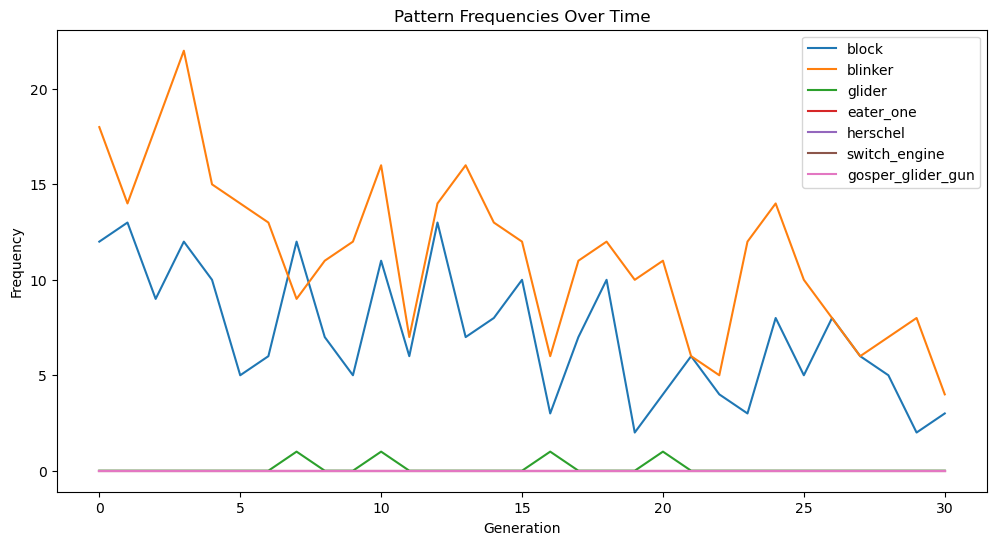

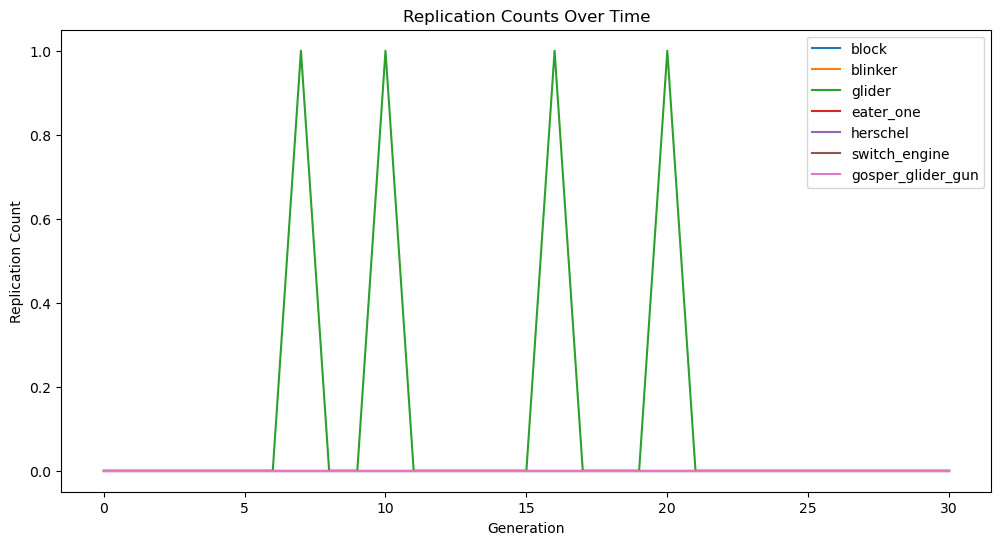

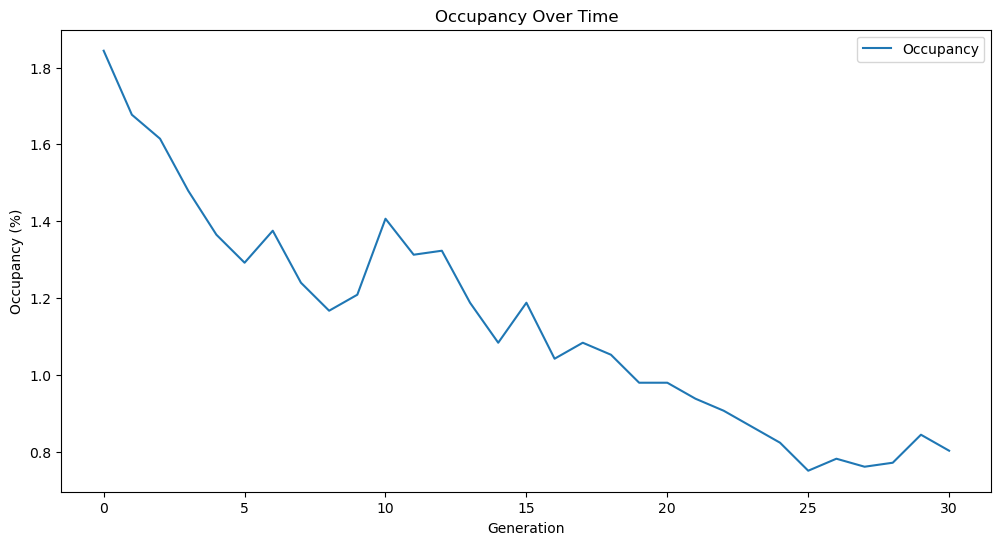

In [31]:
import matplotlib.pyplot as plt

def main():
    pygame.init()
    screen = pygame.display.set_mode((1200, 600))
    clock = pygame.time.Clock()
    cells = np.zeros((80, 120))
    size = 10
    screen.fill((40, 40, 40)) # COLOR_GRID
    rows, cols = 80, 120
    cells = np.zeros((rows, cols), dtype=int)
    reset(cells, rows, cols)
    update(screen, cells, size)
    pygame.display.flip()
    running = False
    drawing = False
    selected_pattern = "glider"
    cont = 0
    update_calls = 0
    update_times = []
    pattern_frequencies_history = []
    replication_counts_history = []
    occupancy_history = []
    previous_cells = cells.copy()

    running_main = True

    while running_main:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                running_main = False
                break
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    running = not running
                elif event.key == pygame.K_q:
                    cells = reset(cells, rows, cols)
                elif event.key == pygame.K_1:
                    selected_pattern = "block"
                elif event.key == pygame.K_2:
                    selected_pattern = "blinker"
                elif event.key == pygame.K_3:
                    selected_pattern = "glider"
                elif event.key == pygame.K_4:
                    selected_pattern = "eater_one"
                elif event.key == pygame.K_5:
                    selected_pattern = "herschel"
                elif event.key == pygame.K_6:
                    selected_pattern = "switch_engine"
                elif event.key == pygame.K_7:
                    selected_pattern = "gosper_glider_gun"
            elif event.type == pygame.MOUSEBUTTONDOWN:
                pos = pygame.mouse.get_pos()
                row, col = pos[1] // size, pos[0] // size
                if event.button == 1:
                    drawing = True
                    cells[row, col] = 1
                elif event.button == 3:
                    cells = insert_pattern(cells, selected_pattern, row, col)
            elif event.type == pygame.MOUSEBUTTONUP and event.button == 1:
                drawing = False
            elif event.type == pygame.MOUSEMOTION and drawing:
                pos = pygame.mouse.get_pos()
                row, col = pos[1] // size, pos[0] // size
                cells[row, col] = 1

        if not running_main:
            break

        screen.fill((40, 40, 40)) #COLOR_GRID

        if update_calls < 100:
            start_time = time.perf_counter()
        if running:
            cont = cont + 1
            previous_cells = cells.copy()
            cells = update(screen, cells, size, with_progress=True)
            pattern_frequencies_history.append(track_pattern_frequency(cells, PATTERNS))
            replication_counts_history.append(track_replication(cells, previous_cells, PATTERNS))
            occupancy_history.append(track_occupancy(cells))

        else:
            update(screen, cells, size)

        if update_calls < 100:
            end_time = time.perf_counter()
            elapsed = end_time - start_time
            update_times.append(elapsed)
            update_calls += 1

        if update_calls == 100:
            mean_time = np.mean(update_times)
            std_time = np.std(update_times)
            print(f"mean time of update (100 iterations): {mean_time:.6f} s ± {std_time:.6f} s")
        update_calls += 1
        pygame.display.update()
        clock.tick(50)
        time.sleep(0.001)

    # When quitting
    plot_pattern_frequencies(pattern_frequencies_history, PATTERNS.keys())
    plot_replication_counts(replication_counts_history, PATTERNS.keys())
    plot_occupancy(occupancy_history)
    plt.show(block=True)

if __name__ == '__main__':
    main()

# Faster computing
**np.roll in the Update Function**

The code uses `np.roll` to shift the grid in eight directions to compute the number of live neighbors for each cell:

- `np.roll(cells, 1, axis=0)` shifts the grid down (each cell gets the value from the cell above, with wrap-around).
- `np.roll(cells, -1, axis=0)` shifts the grid up.
- `np.roll(cells, 1, axis=1)` shifts the grid right.
- `np.roll(cells, -1, axis=1)` shifts the grid left.
- Diagonal shifts are done by combining two rolls (e.g., `np.roll(np.roll(cells, 1, axis=0), 1, axis=1)` shifts down and right).

By summing these eight shifted matrices, the code obtains `n_neighbors`, the total count of live neighbors for each cell.

Then it applies the Game of Life rules:
- A live cell survives if it has 2 or 3 live neighbors.
- A dead cell becomes alive if it has exactly 3 live neighbors.

This vectorized approach using `np.roll` is much faster than iterating over each cell.


# Mean and Uncertainty Formulas

For each time step \(t\), let 
$$
x_{t,1}, \quad x_{t,2}, \quad \dots, \quad x_{t,N}
$$
be the counts of live cells in each of the \(N\) simulations. Then, the formulas used in the code are:

**Mean (Average):**

$$
\bar{x}_t = \frac{1}{N} \sum_{i=1}^{N} x_{t,i}
$$

**Uncertainty (Standard Deviation):**

$$
\sigma_t = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( x_{t,i} - \bar{x}_t \right)^2}
$$


In [21]:
def update(cells):
    n_neighbors = (
          np.roll(cells, 1, axis=0) 
        + np.roll(cells, -1, axis=0)  
        + np.roll(cells, 1, axis=1)  
        + np.roll(cells, -1, axis=1) 
        + np.roll(np.roll(cells, 1, axis=0), 1, axis=1)  
        + np.roll(np.roll(cells, 1, axis=0), -1, axis=1)  
        + np.roll(np.roll(cells, -1, axis=0), 1, axis=1)  
        + np.roll(np.roll(cells, -1, axis=0), -1, axis=1) 
    )
    
    new_cells = ((cells == 1) & ((n_neighbors == 2) | (n_neighbors == 3))) | ((cells == 0) & (n_neighbors == 3))    # life and death rule
    return new_cells.astype(int)

In [22]:
def simulate_iterations(rows, cols,sigma,  iterations=1000, max_steps=100):
    all_live_counts = []
    
    update_times = []
    update_calls = 0

    for _ in range(iterations):
        cells = np.zeros((rows, cols), dtype=int)
        generate_random(cells, sigma)
        
        live_counts = []
        for step in range(max_steps):
            if update_calls < 100:
                start_time = time.perf_counter()
                cells = update(cells)
                end_time = time.perf_counter()
                
                elapsed = end_time - start_time
                update_times.append(elapsed)
                update_calls += 1
                
                if update_calls == 100:
                    mean_time = np.mean(update_times)
                    std_time = np.std(update_times)
                    print(f"mean time of update (100 iterations): {mean_time:.6f} s ± {std_time:.6f} s")
            else:
                cells = update(cells)
            
            live_count = np.sum(cells)
            live_counts.append(live_count)
        
        all_live_counts.append(live_counts)
    
    all_live_counts = np.array(all_live_counts)
    mean_live_counts = np.mean(all_live_counts, axis=0)
    std_live_counts = np.std(all_live_counts, axis=0)
    
    return mean_live_counts, std_live_counts

In [23]:
def generate_random(cells,sigma):
    #sigma = 7
    m = 3  #  number of gaussians
    centers = np.column_stack((np.random.randint(0, rows, size=m), np.random.randint(0, cols, size=m)))
    prob_grid = np.zeros(cells.shape)
    for center in centers:
        distance_squared = (np.indices(cells.shape)[0] - center[0])**2 + (np.indices(cells.shape)[1] - center[1])**2
        prob_grid += np.exp(-distance_squared / (2 * sigma**2))
    prob_grid /= prob_grid.max()
    cells[:, :] = np.random.rand(rows, cols) < prob_grid
    return cells  

mean time of update (100 iterations): 0.000123 s ± 0.000033 s
mean time of update (100 iterations): 0.000099 s ± 0.000009 s
mean time of update (100 iterations): 0.000139 s ± 0.000062 s
mean time of update (100 iterations): 0.000106 s ± 0.000024 s
mean time of update (100 iterations): 0.000103 s ± 0.000012 s
mean time of update (100 iterations): 0.000104 s ± 0.000016 s
mean time of update (100 iterations): 0.000099 s ± 0.000012 s
mean time of update (100 iterations): 0.000105 s ± 0.000022 s
mean time of update (100 iterations): 0.000109 s ± 0.000030 s
mean time of update (100 iterations): 0.000110 s ± 0.000027 s
mean time of update (100 iterations): 0.000115 s ± 0.000035 s
mean time of update (100 iterations): 0.000099 s ± 0.000011 s


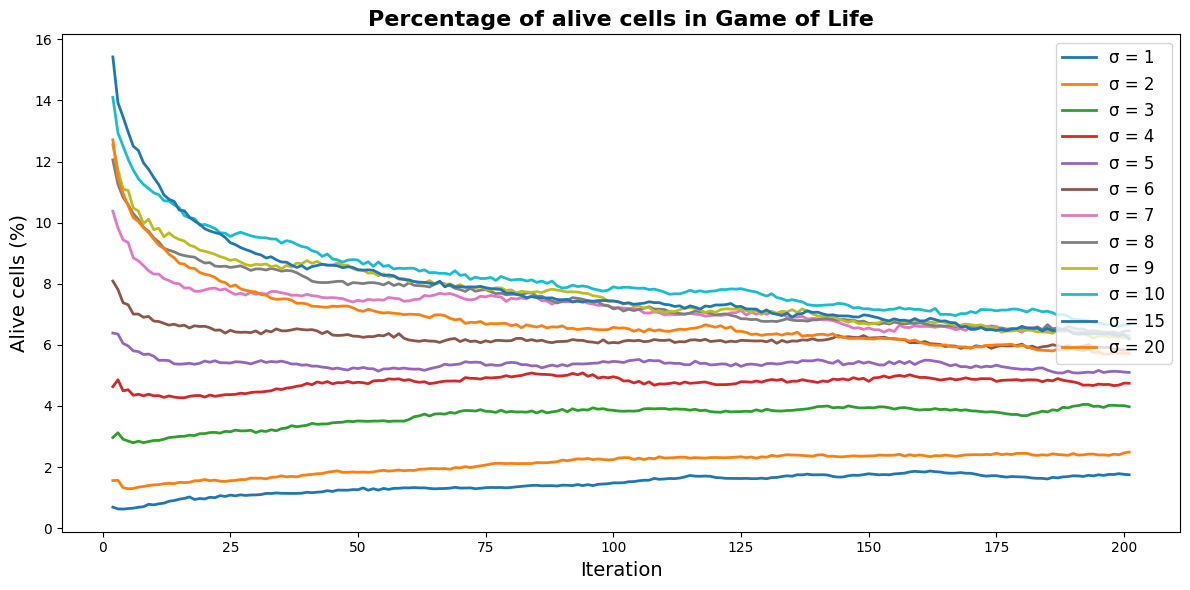

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_live_cells_multiple(sigmas, rows, cols, simulations, max_steps):
    total_cells = rows * cols

    plt.figure(figsize=(12, 6))  

    for s in sigmas:
        mean_live_counts, std_live_counts = simulate_iterations(rows, cols, s, simulations, max_steps)

        mean_live_percent = (mean_live_counts / total_cells) * 100
        iterations = np.arange(2, len(mean_live_percent) + 2)

        plt.plot(iterations, mean_live_percent, label=f"σ = {s}", linewidth=2)

        # std_live_percent = (std_live_counts / total_cells) * 100
        # plt.fill_between(iterations, 
        #                  mean_live_percent - std_live_percent, 
        #                  mean_live_percent + std_live_percent, 
        #                  alpha=0.2)

    plt.title('Percentage of alive cells in Game of Life', fontsize=16, fontweight='bold')
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Alive cells (%)', fontsize=14)

    plt.legend(frameon=True, fontsize=12, loc='upper right')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Parametri
sigma = [1,2,3,4,5, 6,7,8,9,10,15,20]
rows, cols = 40, 60
simulations = 100
max_steps = 200

# Esecuzione
plot_live_cells_multiple(sigma, rows, cols, simulations, max_steps)
